# R notebook for proteomic data analysis of soy-tolerant rainbow trout (Tissues: plasma and intestine, RBT Strains: commercial and select strain, Diets: FM and PM)

### Read in the required packages

In [1]:
library('tidyverse')
library('DEP')
library('pheatmap')
library('ggplotify')
library('SummarizedExperiment')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message in fun(libname, pkgname):
“mzR has been built against a different Rcpp version (1.0.9)
than is installed on your system (1.0.13). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.”
Loading required package: MatrixGenerics

### Read in protein quantification files

In [2]:
LFQsum_plas <- read.csv('PlasmaSummaryTab.csv')
LFQsum_int <- read.csv('IntSummaryTab.csv')

### Check for duplicate protein hits

In [3]:
LFQsum_plas$UniProtAcc %>% duplicated() %>% any()
LFQsum_int$UniProtAcc %>% duplicated() %>% any()

[1] TRUE

[1] TRUE

### T1 and T2 datasets have duplicated UniProt entries - merge the data by matching row names from T1 results and T2 results

In [4]:
LFQsum_plas$UniProtAcc <- as.factor(LFQsum_plas$UniProtAcc)
LFQsum_plas$GeneNames <- as.factor(LFQsum_plas$GeneNames)

LFQsum_int$UniProtAcc <- as.factor(LFQsum_int$UniProtAcc)
LFQsum_int$GeneNames <- as.factor(LFQsum_int$GeneNames)

LFQmerged_plas <- LFQsum_plas %>% group_by(UniProtAcc, GeneNames) %>% summarise_all( ~ mean(.x, na.rm = TRUE))
LFQmerged_int <- LFQsum_int %>% group_by(UniProtAcc, GeneNames) %>% summarise_all( ~ mean(.x, na.rm = TRUE))

In [5]:
dim(LFQmerged_plas)
dim(LFQmerged_int)

LFQmerged_int$UniProtAcc %>% duplicated() %>% any()
LFQmerged_plas$UniProtAcc %>% duplicated() %>% any()

[1] 3912   74

[1] 1008   74

[1] FALSE

[1] FALSE

#### All uniprots are unique, but multiple gene names are applied to multiple UniProts

In [6]:
LFQmerged_plas %>% group_by(UniProtAcc) %>% summarize(frequency = n()) %>% arrange(desc(frequency)) %>% filter(frequency > 1) %>% nrow()
LFQmerged_plas %>% group_by(GeneNames) %>% summarize(frequency = n()) %>% arrange(desc(frequency)) %>% filter(frequency > 1) %>% nrow()

[1] 0

[1] 790

### Compare proteins between datasets

In [7]:
length(setdiff(colnames(LFQmerged_int), colnames(LFQmerged_plas))) # do samples match? 0 means yes
length(setdiff(LFQmerged_int$UniProtAcc, LFQmerged_plas$UniProtAcc)) # proteins in intestine but not in plasma
length(setdiff(LFQmerged_plas$UniProtAcc, LFQmerged_int$UniProtAcc)) # proteins in plasma but not in intestine
length(LFQmerged_plas$UniProtAcc) # total proteins identified in plasma
length(LFQmerged_int$UniProtAcc) # total proteins identified in intestine
length(unique(LFQmerged_plas$UniProtAcc, LFQmerged_int$UniProtAcc)) # total proteins detected between both datasets

[1] 0

[1] 841

[1] 3745

[1] 3912

[1] 1008

[1] 3912

In [8]:
common <- intersect(LFQmerged_int$UniProtAcc, LFQmerged_plas$UniProtAcc)
plasOnly <- setdiff(LFQmerged_plas$UniProtAcc, LFQmerged_int$UniProtAcc)
intOnly <- setdiff(LFQmerged_int$UniProtAcc, LFQmerged_plas$UniProtAcc)
UniProtIDs <- list(Plasma = LFQmerged_plas$UniProtAcc, Intestine = LFQmerged_int$UniProtAcc)
ProtIDs <- list(Plasma = LFQmerged_plas$GeneNames, Intestine = LFQmerged_int$GeneNames)

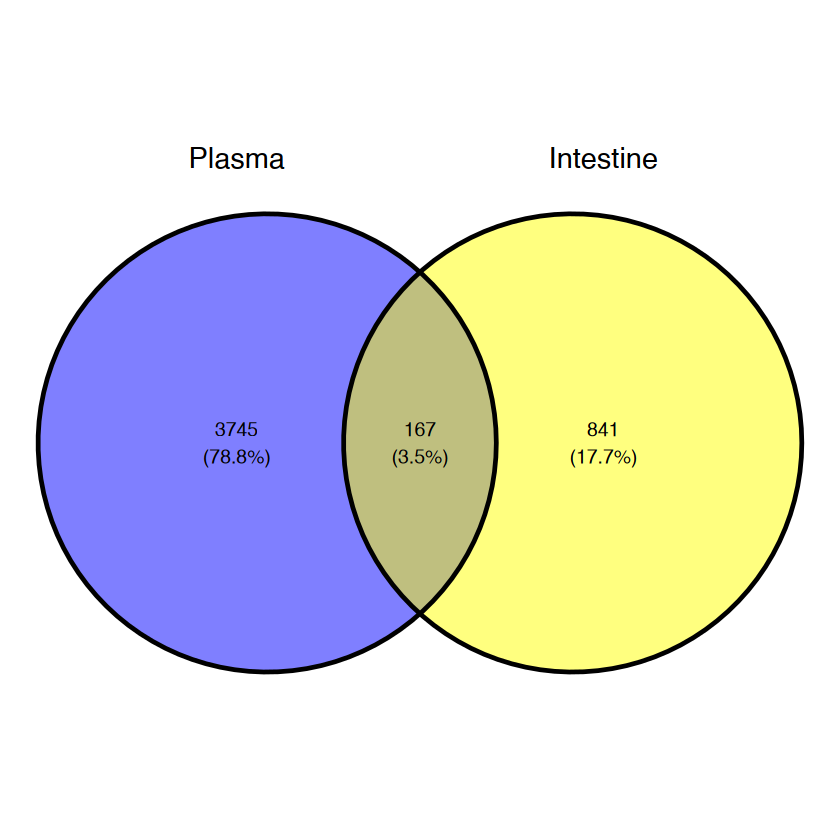

In [9]:
ggvenn::ggvenn(UniProtIDs)
ggsave('Figures/TissueProteomVenn.tiff', width=5.5, height=4, units='in')

### Build metadata file for statistical pairwise group tests

In [10]:
metaData <- separate(as.data.frame(colnames(LFQmerged_int)[-c(1,2)]), 1, c('Timepoint', 'Strain', 'Diet', 'replicate'), '_') 
metaData <- metaData %>% mutate(label=colnames(LFQmerged_int)[-c(1,2)], .before = 'Timepoint') %>% mutate(condition = paste0(Timepoint,"_", Strain, "_", Diet), .before=replicate) %>% select(label,condition,replicate)
row.names(metaData) <- seq.int(nrow(metaData))
head(metaData)
table(metaData$condition)

,label,condition,replicate
,<chr>,<chr>,<chr>
1,T1_ARS_FM_1,T1_ARS_FM,1
2,T1_ARS_FM_2,T1_ARS_FM,2
3,T1_ARS_FM_3,T1_ARS_FM,3
4,T1_ARS_FM_4,T1_ARS_FM,4
5,T1_ARS_FM_5,T1_ARS_FM,5
6,T1_ARS_FM_6,T1_ARS_FM,6



T1_ARS_FM T1_ARS_PM  T1_TL_FM  T1_TL_PM T2_ARS_FM T2_ARS_PM  T2_TL_FM  T2_TL_PM 
        9         9         9         9         9         9         9         9 

### Relables column names for DEP

In [11]:
LFQmerged_plasUniq <- make_unique(LFQmerged_plas, "GeneNames", "UniProtAcc", delim = ";")
LFQmerged_plasUniq <- LFQmerged_plasUniq %>% mutate_all(~ifelse(is.nan(.), NA, .))

LFQmerged_intUniq <- make_unique(LFQmerged_int, "GeneNames", "UniProtAcc", delim = ";")
LFQmerged_intUniq <- LFQmerged_intUniq %>% mutate_all(~ifelse(is.nan(.), NA, .))

### Calculate std. error of measurements of raw data and plot in comparisons to normalized dataset (variance stabilizing transformation)

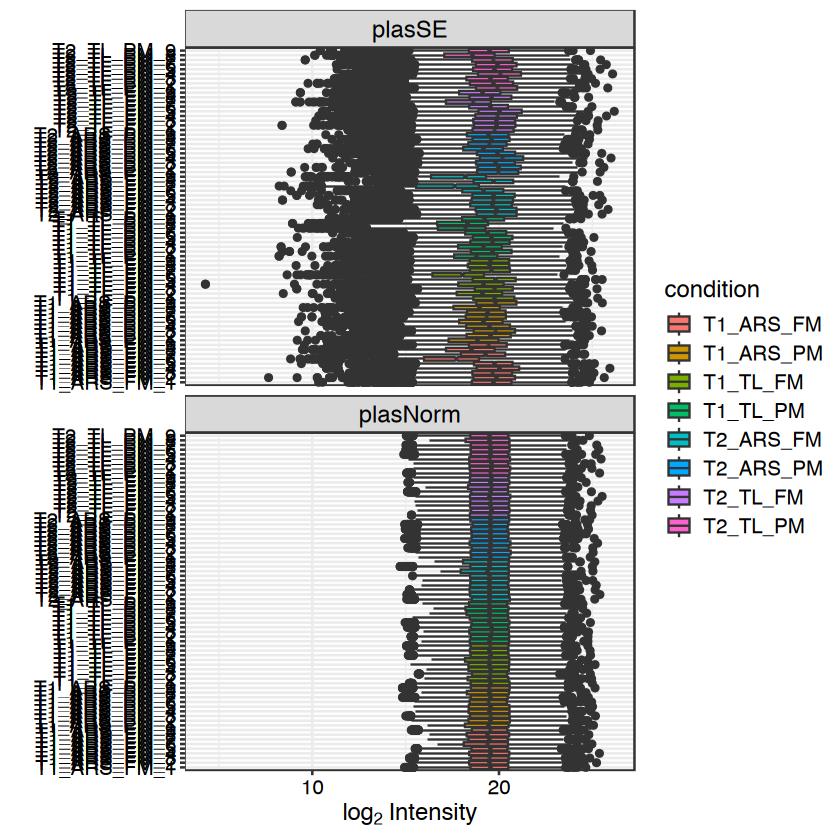

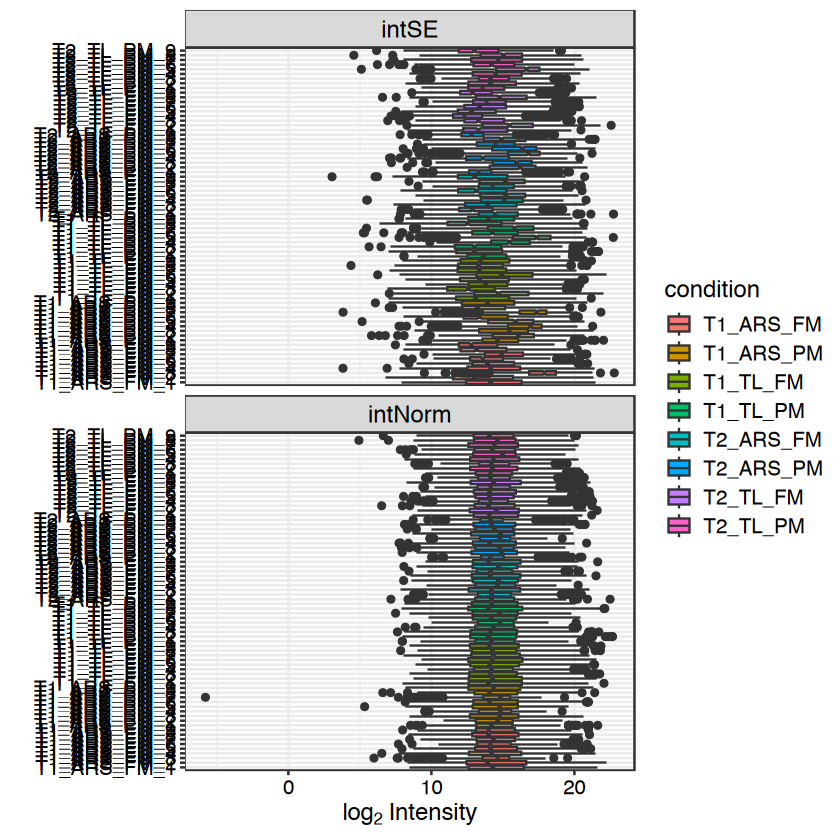

In [12]:
sampCols <- grep("T", colnames(LFQmerged_plasUniq)) # grep captures all groups
plasSE <- make_se(LFQmerged_plasUniq, sampCols, metaData)

sampIntCols <- grep("T", colnames(LFQmerged_intUniq))
intSE <- make_se(LFQmerged_intUniq, sampIntCols, metaData)

plasNorm <- normalize_vsn(plasSE)
plot_normalization(plasSE, plasNorm)

intNorm <- normalize_vsn(intSE) 
plot_normalization(intSE, intNorm) # intestinal data did not normalize as well as plasma

### Test imputation of any missing data? No missing data present - no imputation necessary. Proceed with normalized data

Warning message:
“No missing values in 'plasNorm'. Returning the unchanged object.”
Warning message:
“No missing values in 'intNorm'. Returning the unchanged object.”


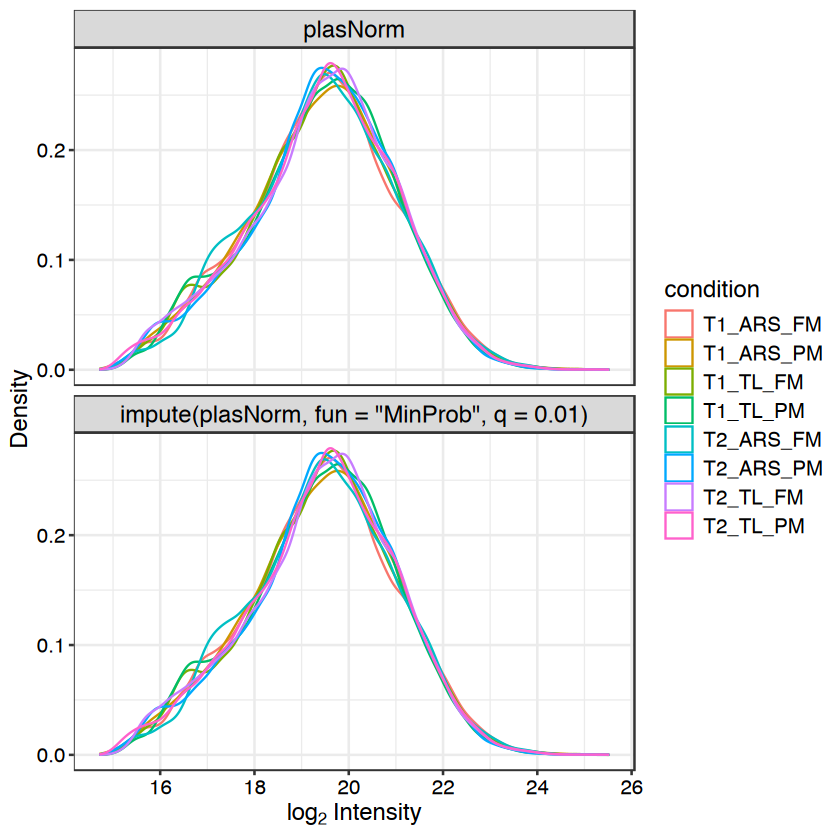

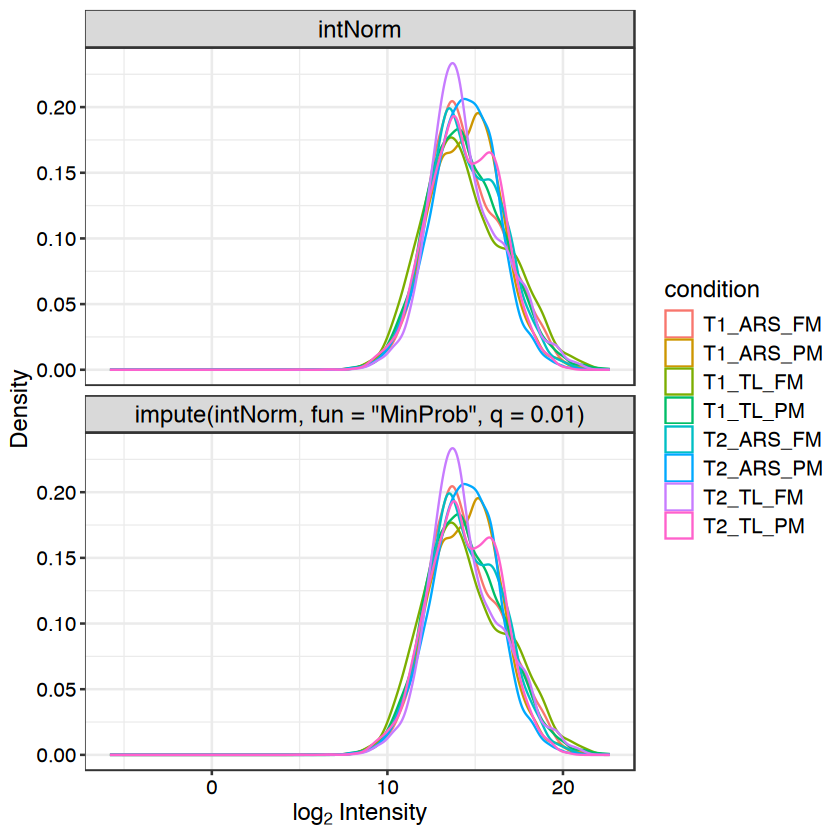

In [13]:
plot_imputation(plasNorm, impute(plasNorm, fun="MinProb", q=0.01))

plot_imputation(intNorm, impute(intNorm, fun="MinProb", q=0.01))

## Run statistical test - all pairwise contrasts of interest - statistical thresholds of p-adjust ≤ 0.05 and |log-fold change| > 1

### Build list of contracts of interest

In [14]:
groupsComps <- c("T1_ARS_FM_vs_T1_TL_FM",#1
                 "T2_ARS_FM_vs_T2_TL_FM",#2
                 "T1_ARS_PM_vs_T1_TL_PM",#3
                 "T2_ARS_PM_vs_T2_TL_PM",#4
                 "T1_ARS_FM_vs_T1_ARS_PM",#5
                 "T2_ARS_FM_vs_T2_ARS_PM",#6
                 "T1_TL_FM_vs_T1_TL_PM",#7
                 "T2_TL_FM_vs_T2_TL_PM",#8
                 "T1_ARS_FM_vs_T2_ARS_FM",#9
                 "T1_ARS_PM_vs_T2_ARS_PM",#10
                 "T1_TL_FM_vs_T2_TL_FM",#11
                 "T1_TL_PM_vs_T2_TL_PM", #12
                 "T2_ARS_FM_vs_T2_TL_PM") #13

### Plasma dataset

In [15]:
plas_all_contrasts <- test_diff(plasNorm, type = "manual", test = groupsComps)
plas_dep <- add_rejections(plas_all_contrasts, alpha = 0.05, lfc = 1)
plas_dep

write.csv(get_results(plas_dep), 'PlasmaDEP_Results.csv')

Tested contrasts: T1_ARS_FM_vs_T1_TL_FM, T2_ARS_FM_vs_T2_TL_FM, T1_ARS_PM_vs_T1_TL_PM, T2_ARS_PM_vs_T2_TL_PM, T1_ARS_FM_vs_T1_ARS_PM, T2_ARS_FM_vs_T2_ARS_PM, T1_TL_FM_vs_T1_TL_PM, T2_TL_FM_vs_T2_TL_PM, T1_ARS_FM_vs_T2_ARS_FM, T1_ARS_PM_vs_T2_ARS_PM, T1_TL_FM_vs_T2_TL_FM, T1_TL_PM_vs_T2_TL_PM, T2_ARS_FM_vs_T2_TL_PM



class: SummarizedExperiment 
dim: 3912 72 
metadata(0):
assays(1): ''
rownames(3912): A0A060VLZ3 DYNC1LI2 ... PCNA PCNA.1
rowData names(83): name UniProtAcc ... T2_TL_FM_vs_T2_TL_PM_significant
  significant
colnames(72): T1_ARS_FM_1 T1_ARS_FM_2 ... T2_TL_PM_8 T2_TL_PM_9
colData names(4): label ID condition replicate

### Intestinal dataset

In [16]:
int_all_contrasts <- test_diff(intNorm, type = "manual", test = groupsComps)
int_dep <- add_rejections(int_all_contrasts, alpha = 0.05, lfc = 1)
int_dep

write.csv(get_results(int_dep), 'IntestineDEP_Results.csv')

Tested contrasts: T1_ARS_FM_vs_T1_TL_FM, T2_ARS_FM_vs_T2_TL_FM, T1_ARS_PM_vs_T1_TL_PM, T2_ARS_PM_vs_T2_TL_PM, T1_ARS_FM_vs_T1_ARS_PM, T2_ARS_FM_vs_T2_ARS_PM, T1_TL_FM_vs_T1_TL_PM, T2_TL_FM_vs_T2_TL_PM, T1_ARS_FM_vs_T2_ARS_FM, T1_ARS_PM_vs_T2_ARS_PM, T1_TL_FM_vs_T2_TL_FM, T1_TL_PM_vs_T2_TL_PM, T2_ARS_FM_vs_T2_TL_PM



class: SummarizedExperiment 
dim: 1008 72 
metadata(0):
assays(1): ''
rownames(1008): A0A060VLZ3 LUZP2 ... UBA52 CBR1
rowData names(83): name UniProtAcc ... T2_TL_FM_vs_T2_TL_PM_significant
  significant
colnames(72): T1_ARS_FM_1 T1_ARS_FM_2 ... T2_TL_PM_8 T2_TL_PM_9
colData names(4): label ID condition replicate

### Reformatting and modifying sample naming for publication

In [17]:
plas_dep$timepoint <- factor(str_split_fixed(plas_dep$condition, '_', 2)[,1], levels=c('T1','T2'))
plas_dep$diet <- factor(str_split_fixed(plas_dep$condition, '_', 3)[,3], levels=c('FM','PM'))
plas_dep$strain <- factor(str_split_fixed(plas_dep$condition, '_', 3)[,2], levels=c('ARS', 'TL'))
plas_dep$strainDiet <- factor(paste0(plas_dep$strain,'_',plas_dep$diet), levels=c('ARS_FM', 'TL_FM','ARS_PM','TL_PM'))

int_dep$timepoint <- factor(str_split_fixed(int_dep$condition, '_', 2)[,1], levels=c('T1','T2'))
int_dep$diet <- factor(str_split_fixed(int_dep$condition, '_', 3)[,3], levels=c('FM','PM'))
int_dep$strain <- factor(str_split_fixed(int_dep$condition, '_', 3)[,2], levels=c('ARS', 'TL'))
int_dep$strainDiet <- factor(paste0(int_dep$strain,'_',int_dep$diet), levels=c('ARS_FM', 'TL_FM','ARS_PM','TL_PM'))

In [18]:
colData(plas_dep)$condition <- gsub("TL", "Com", colData(plas_dep)$condition)
colData(plas_dep)$condition <- gsub("ARS", "Sel", colData(plas_dep)$condition)
colnames(rowData(plas_dep)) <- gsub("TL", "Com", colnames(rowData(plas_dep)))
colnames(rowData(plas_dep)) <- gsub("ARS", "Sel", colnames(rowData(plas_dep)))

colData(int_dep)$condition <- gsub("TL", "Com", colData(int_dep)$condition)
colData(int_dep)$condition <- gsub("ARS", "Sel", colData(int_dep)$condition)
colnames(rowData(int_dep)) <- gsub("TL", "Com", colnames(rowData(int_dep)))
colnames(rowData(int_dep)) <- gsub("ARS", "Sel", colnames(rowData(int_dep)))

### Plot PCA - using 500 most variable proteins - using DEP wrapper to conduct PCA - then modify plot legend and format using ggplot

In [19]:
PlasmaPCA <- plot_pca(plas_dep, x = 1, y = 2, n = 1000, indicate=c(color='strainDiet',
                                                                   shape='strainDiet',
                                                                   facet_wrap='timepoint'))

IntestinePCA <- plot_pca(int_dep, x = 1, y = 2, n = 1000, indicate=c(color='strainDiet',
                                                                   shape='strainDiet',
                                                                   facet_wrap='timepoint'))

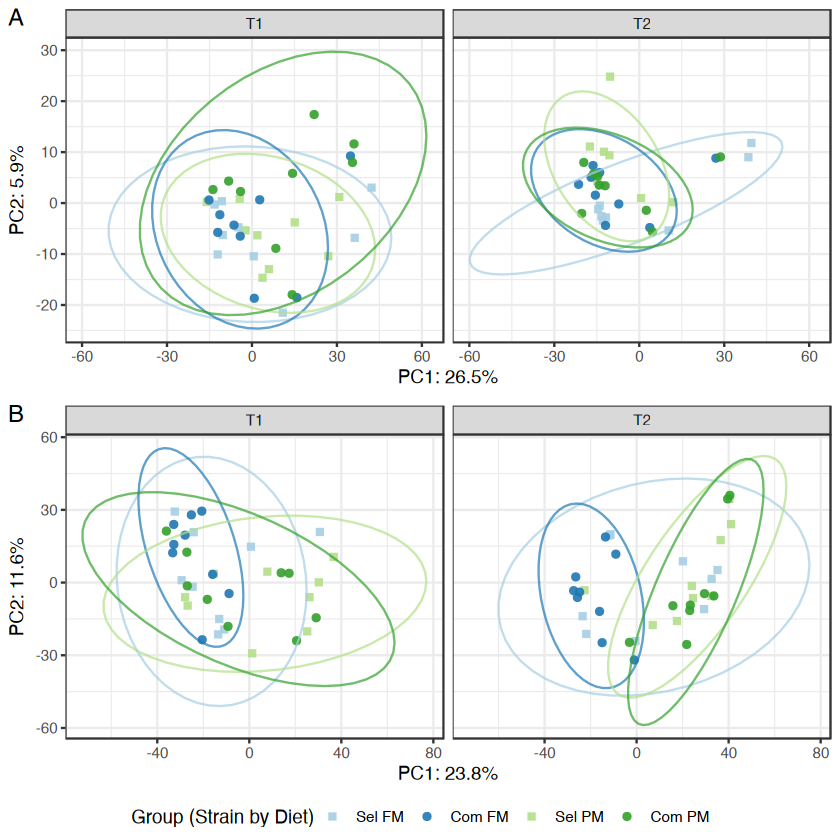

In [20]:
# Load necessary library for the color palette
library(RColorBrewer)

# Get the Paired color palette and select colors starting from the 4th
paired_colors <- brewer.pal(n = 12, name = "Paired")[c(1,2,3,4)]

set.seed(123)

# Plasma PCA plot with updated shapes and selected color palette
PlasPCA <- ggplot(PlasmaPCA$data, aes(x=PC1, y=PC2)) + 
  geom_point(aes(color=strainDiet, shape=strainDiet), size=2, alpha=0.9, show.legend = FALSE) + 
  facet_wrap('timepoint') + 
  stat_ellipse(aes(color=strainDiet), alpha=0.7, show.legend = FALSE) + 
  scale_shape_manual(name = 'Group (Strain by Diet)',
                     labels = c('Sel FM','Com FM','Sel PM','Com PM'),
                     values = c(15, 16, 15, 16)) +  # Updated shapes
  theme_bw() + 
  labs(x = PlasmaPCA$labels$x, y = PlasmaPCA$labels$y) + 
  scale_color_manual(name = 'Group (Strain by Diet)',
                     labels = c('Sel FM','Com FM','Sel PM','Com PM'),
                     values = paired_colors)  # Manually set colors starting from the 4th

# Intestine PCA plot with updated shapes and selected color palette
IntPCA <- ggplot(IntestinePCA$data, aes(x=PC1, y=PC2)) + 
  geom_point(aes(color=strainDiet, shape=strainDiet), size=2, alpha=0.9, show.legend = TRUE) + 
  facet_wrap('timepoint') + 
  stat_ellipse(aes(color=strainDiet), alpha=0.7, show.legend = FALSE) + 
  theme_bw() + 
  scale_shape_manual(name = 'Group (Strain by Diet)',
                     labels = c('Sel FM','Com FM','Sel PM','Com PM'),
                     values = c(15, 16, 15, 16)) +  # Updated shapes
  labs(x = IntestinePCA$lab$x, y = IntestinePCA$lab$y) + 
  guides(color=guide_legend(title="Group (Strain by Diet)")) + 
  scale_color_manual(name = 'Group (Strain by Diet)',
                     labels = c('Sel FM','Com FM','Sel PM','Com PM'),
                     values = paired_colors)  # Manually set colors starting from the 4th

# Arrange the two plots
ggpubr::ggarrange(PlasPCA, IntPCA, common.legend = TRUE, legend = 'bottom', nrow = 2, labels = 'AUTO')

# Save the plot
ggsave('Figures/PlasmaProteomics_PCAtop500.tiff', width=5, height=5, units='in')

### Summarize DEPs - 21 DEPs in plasma; 0 in intestine 
#### first show how many are significant (p.adj < 0.05 and |LFC| > 1.0
#### then show how many have a signifciant p.adj (< 0.05), but not LFC threshold

In [21]:
get_results(plas_dep) %>% filter(significant) %>% nrow() # LFC and p.adj
get_results(plas_dep) %>% select(contains('p.adj')) %>% filter_all(any_vars(. <= 0.05)) %>% nrow() # p.adj only

get_results(int_dep) %>% filter(significant) %>% nrow() # LFC and p.adj
get_results(int_dep) %>% select(contains('p.adj')) %>% filter_all(any_vars(. <= 0.05)) %>% nrow() # p.adj only

[1] 21

[1] 38

[1] 0

[1] 0

#### Plot the significant p.adj DEPs from the plasma

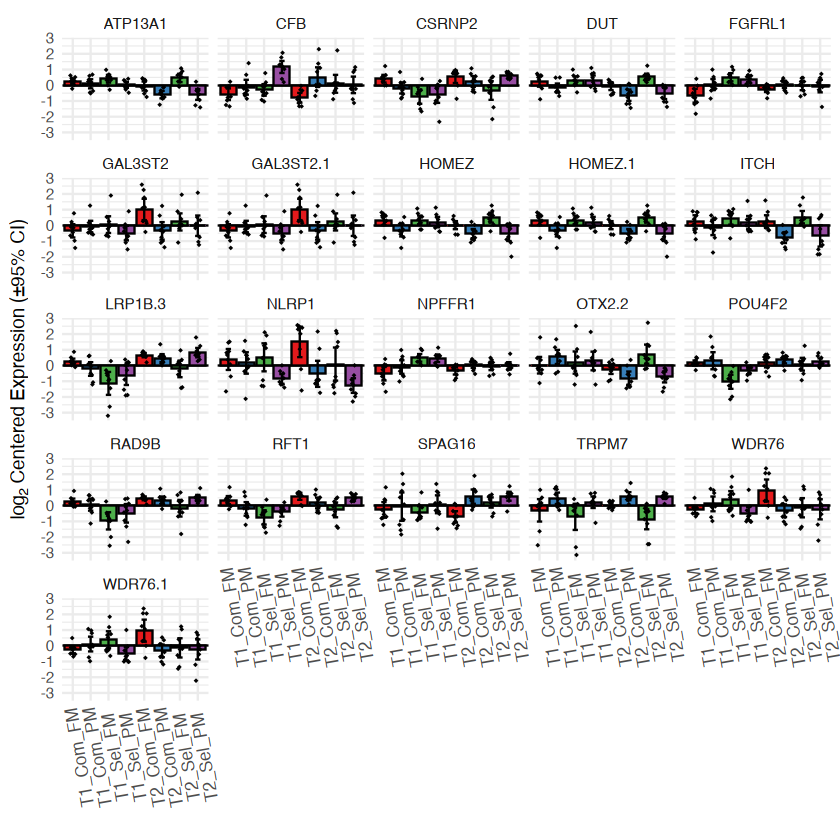

In [22]:
padjSigPlasDEP <- get_results(plas_dep) %>% filter(significant) %>% dplyr::select(name) %>% as.list() %>% unname() %>% unlist()

padjSigPlasPlot <- plot_single(plas_dep, 
                                proteins = padjSigPlasDEP, 
                                type = "centered", 
                                plot=TRUE) + xlab('') + ylab(expression(log[2]~"Centered Expression"~"(\u00B195% CI)"))  + theme_minimal() + theme(legend.position = 'none', 
                                                                            axis.text.x = element_text(size=10, angle=100)) + scale_color_manual(values=rep('black', 9)) 
padjSigPlasPlot$layers[[3]]$aes_params$size <- 1
padjSigPlasPlot$layers[[2]]$aes_params$fill <- rep(rep(RColorBrewer::brewer.pal(n = 4, name = "Set1"),2), 21)
padjSigPlasPlot
ggsave('Figures/PadjSigGenesPlasmaExpressionPlot.tiff', units='in', dpi=300, scale=1.25, width=6.5, height=7, bg='white')

### No significant proteins in int when using p.adj. Work off p.val instead of the p.adj and then use a more conservative threshold p < 0.01

In [23]:
## Make a new function to annotate DEP results
add_rejections_p.val <- function(diff, pValue = 0.01, lfc = 1.0) {
  # Show error if inputs are not the required classes
  if(is.integer(pValue)) pValue <- as.numeric(pValue)
  if(is.integer(lfc)) lfc <- as.numeric(lfc)
  assertthat::assert_that(inherits(diff, "SummarizedExperiment"),
                          is.numeric(pValue),
                          length(pValue) == 1,
                          is.numeric(lfc),
                          length(lfc) == 1)

  row_data <- rowData(diff, use.names = FALSE) %>%
    as.data.frame()
  # Show error if inputs do not contain required columns
  if(any(!c("name", "ID") %in% colnames(row_data))) {
    stop("'name' and/or 'ID' columns are not present in '",
         deparse(substitute(diff)),
         "'\nRun make_unique() and make_se() to obtain the required columns",
         call. = FALSE)
  }
  if(length(grep("_p.val|_diff", colnames(row_data))) < 1) {
    stop("'[contrast]_diff' and/or '[contrast]_p.val' columns are not present in '",
         deparse(substitute(diff)),
         "'\nRun test_diff() to obtain the required columns",
         call. = FALSE)
  }

  # get all columns with adjusted p-values and log2 fold changes
  cols_p <- grep("_p.val", colnames(row_data))
  cols_diff <- grep("_diff", colnames(row_data))

  # Mark differential expressed proteins by
  # applying pValue and log2FC parameters per protein
  if(length(cols_p) == 1) {
    rowData(diff)$significant <-
      row_data[, cols_p] <= pValue & abs(row_data[, cols_diff]) >= lfc
    rowData(diff)$contrast_significant <-
      rowData(diff, use.names = FALSE)$significant
    colnames(rowData(diff))[ncol(rowData(diff, use.names = FALSE))] <-
      gsub("p.val", "significant", colnames(row_data)[cols_p])
  }
  if(length(cols_p) > 1) {
    p_reject <- row_data[, cols_p] <= pValue
    p_reject[is.na(p_reject)] <- FALSE
    diff_reject <- abs(row_data[, cols_diff]) >= lfc
    diff_reject[is.na(diff_reject)] <- FALSE
    sign_df <- p_reject & diff_reject
    sign_df <- cbind(sign_df,
      significant = apply(sign_df, 1, function(x) any(x)))
    colnames(sign_df) <- gsub("_p.val", "_significant", colnames(sign_df))

    sign_df <- cbind(name = row_data$name, as.data.frame(sign_df))
    rowData(diff) <- merge(rowData(diff, use.names = FALSE), sign_df,
                           by = "name")
  }
  return(diff)
}

In [24]:
plas_dep_p.val <- add_rejections_p.val(plas_all_contrasts, pValue = 0.01, lfc = 1)
get_results(plas_dep_p.val) %>% filter(significant) %>% nrow()

colData(plas_dep_p.val)$condition <- gsub("TL", "Com", colData(plas_dep_p.val)$condition)
colData(plas_dep_p.val)$condition <- gsub("ARS", "Sel", colData(plas_dep_p.val)$condition)
colnames(rowData(plas_dep_p.val)) <- gsub("TL", "Com", colnames(rowData(plas_dep_p.val)))
colnames(rowData(plas_dep_p.val)) <- gsub("ARS", "Sel", colnames(rowData(plas_dep_p.val)))

int_dep_p.val <- add_rejections_p.val(int_all_contrasts, pValue = 0.01, lfc = 1)
get_results(int_dep_p.val) %>% filter(significant) %>% nrow()

colData(int_dep_p.val)$condition <- gsub("TL", "Com", colData(int_dep_p.val)$condition)
colData(int_dep_p.val)$condition <- gsub("ARS", "Sel", colData(int_dep_p.val)$condition)
colnames(rowData(int_dep_p.val)) <- gsub("TL", "Com", colnames(rowData(int_dep_p.val)))
colnames(rowData(int_dep_p.val)) <- gsub("ARS", "Sel", colnames(rowData(int_dep_p.val)))


[1] 452

[1] 379

### Compare the log-fold changes among DEPs

In [25]:
# Adjust group labels in comparison list
groupsComps <- gsub("ARS", "Sel", groupsComps)
groupsComps <- gsub("TL", "Com", groupsComps)
groupsComps

# Function to generate volcano plot data and add Comparison column
generate_volcano_data <- function(dep_data, comparison_id) {
  volcano_data <- plot_volcano(dep_data, comparison_id, plot = FALSE)
  volcano_data$Comparison <- comparison_id
  return(volcano_data)
}

# Initialize empty dataframes for plasma and intestine
plasma_combined <- data.frame()
intestine_combined <- data.frame()

# Iterate over the 'groupComps' list for plasma and intestine datasets
for (comparison in groupsComps) {
  # For plasma data
  plasma_volcano <- generate_volcano_data(plas_dep_p.val, comparison)
  plasma_combined <- rbind(plasma_combined, plasma_volcano)
  
  # For intestine data
  intestine_volcano <- generate_volcano_data(int_dep_p.val, comparison)
  intestine_combined <- rbind(intestine_combined, intestine_volcano)
}

# Summary function to calculate mean, sd, and max for positive and negative fold changes
summarize_fold_changes <- function(df) {
  positive_fc <- df$log2_fold_change[df$log2_fold_change > 0]
  negative_fc <- df$log2_fold_change[df$log2_fold_change < 0]
  
  summary_stats <- data.frame(
    absMean_FC = mean(abs(df$log2_fold_change), na.rm = TRUE),
    absSD_FC = sd(abs(df$log2_fold_change), na.rm = TRUE),
    Mean_Positive_FC = mean(positive_fc, na.rm = TRUE),
    SD_Positive_FC = sd(positive_fc, na.rm = TRUE),
    Max_Positive_FC = max(positive_fc, na.rm = TRUE),
    Mean_Negative_FC = mean(negative_fc, na.rm = TRUE),
    SD_Negative_FC = sd(negative_fc, na.rm = TRUE),
    Max_Negative_FC = min(negative_fc, na.rm = TRUE)  # For negative, min gives the largest negative value
  )
  
  return(summary_stats)
}

# Analyze and summarize the log2_fold_change for both plasma and intestine data
plasma_summary <- summarize_fold_changes(plasma_combined)
intestine_summary <- summarize_fold_changes(intestine_combined)

# Display results
print("Plasma Summary:")
plasma_summary

print("Intestine Summary:")
intestine_summary

[1] "T1_Sel_FM_vs_T1_Com_FM" "T2_Sel_FM_vs_T2_Com_FM" "T1_Sel_PM_vs_T1_Com_PM"
 [4] "T2_Sel_PM_vs_T2_Com_PM" "T1_Sel_FM_vs_T1_Sel_PM" "T2_Sel_FM_vs_T2_Sel_PM"
 [7] "T1_Com_FM_vs_T1_Com_PM" "T2_Com_FM_vs_T2_Com_PM" "T1_Sel_FM_vs_T2_Sel_FM"
[10] "T1_Sel_PM_vs_T2_Sel_PM" "T1_Com_FM_vs_T2_Com_FM" "T1_Com_PM_vs_T2_Com_PM"
[13] "T2_Sel_FM_vs_T2_Com_PM"

[1] "Plasma Summary:"


absMean_FC,absSD_FC,Mean_Positive_FC,SD_Positive_FC,Max_Positive_FC,Mean_Negative_FC,SD_Negative_FC,Max_Negative_FC
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3104889,0.2659278,0.2979245,0.2451829,2.111548,-0.3236419,0.2854502,-2.489964


[1] "Intestine Summary:"


absMean_FC,absSD_FC,Mean_Positive_FC,SD_Positive_FC,Max_Positive_FC,Mean_Negative_FC,SD_Negative_FC,Max_Negative_FC
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7320954,0.6299874,0.7500332,0.6678203,6.113333,-0.7139704,0.5887946,-4.968716


In [26]:
plasma_combined %>% filter(significant) %>% arrange(desc(abs(log2_fold_change))) %>% head(20)

,protein,log2_fold_change,p_value_-log10,significant,Comparison
,<chr>,<dbl>,<dbl>,<lgl>,<chr>
1,POGZ,-2.489964,3.282744,TRUE,T1_Sel_PM_vs_T2_Sel_PM
2,TPRXL.1,-2.269781,2.417529,TRUE,T1_Com_PM_vs_T2_Com_PM
3,GORAB,-2.246413,2.978160,TRUE,T1_Sel_PM_vs_T2_Sel_PM
4,NPHP4,-2.211419,5.214038,TRUE,T1_Sel_PM_vs_T2_Sel_PM
5,CDAN1,-2.151789,4.190404,TRUE,T1_Sel_PM_vs_T2_Sel_PM
6,A0A060X892,2.111548,2.063994,TRUE,T1_Com_PM_vs_T2_Com_PM
7,DENND1A,-2.107055,3.565586,TRUE,T1_Com_FM_vs_T1_Com_PM
8,MUC17,-2.061914,2.012000,TRUE,T1_Com_PM_vs_T2_Com_PM
9,GRIK3,-2.056066,2.263515,TRUE,T1_Com_PM_vs_T2_Com_PM


In [27]:
intestine_combined %>% filter(significant) %>% arrange(desc(abs(log2_fold_change))) %>% head(50)

,protein,log2_fold_change,p_value_-log10,significant,Comparison
,<chr>,<dbl>,<dbl>,<lgl>,<chr>
1,TTC5,6.113333,6.094182,TRUE,T2_Com_FM_vs_T2_Com_PM
2,IQSEC1,6.031692,6.253606,TRUE,T2_Com_FM_vs_T2_Com_PM
3,NOG,5.962413,6.233183,TRUE,T2_Com_FM_vs_T2_Com_PM
4,ZC3H14,5.879426,6.190074,TRUE,T2_Com_FM_vs_T2_Com_PM
5,UBR2,5.714976,5.236583,TRUE,T2_Com_FM_vs_T2_Com_PM
6,NBEA,5.390740,5.305815,TRUE,T2_Com_FM_vs_T2_Com_PM
7,SPA17,5.384462,5.820407,TRUE,T2_Com_FM_vs_T2_Com_PM
8,TEX14,5.287661,5.440732,TRUE,T2_Com_FM_vs_T2_Com_PM
9,KNG1,5.281390,5.378575,TRUE,T2_Com_FM_vs_T2_Com_PM


### Save these overall DEP results

In [28]:
plasmaResults <- get_results(plas_dep_p.val) %>% filter(significant) %>% dplyr::select(-contains(c('significant','p.adj', 'centered')))
plasmaResults %>% nrow()

write.csv(filter(plasma_combined, significant), 'Figures/Supplemental_FinalPlasmaResults.csv', row.names = FALSE)



intestineResults <- get_results(int_dep_p.val) %>% filter(significant) %>% dplyr::select(-contains(c('significant','p.adj', 'centered')))
intestineResults %>% nrow()

write.csv(filter(intestine_combined, significant), 'Figures/Supplemental_FinalIntestineResults.csv', row.names = FALSE)

[1] 452

[1] 379

#### Plot unique and shared DEPs between the two tissues

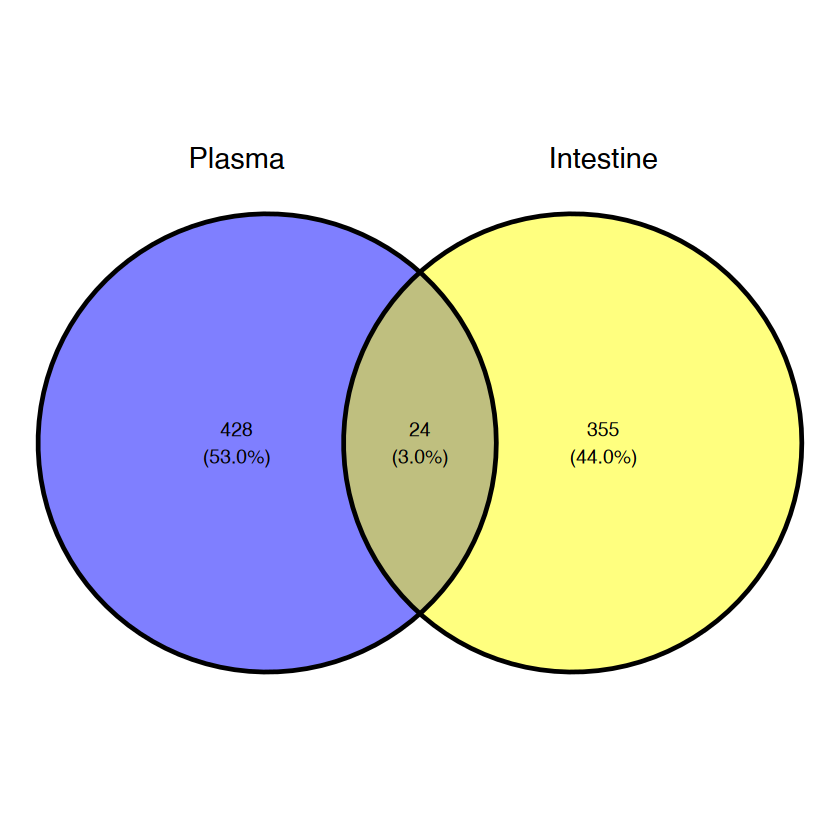

In [29]:
DEPList <- list(Plasma = plasmaResults$name, Intestine = intestineResults$name)
ggvenn::ggvenn(DEPList)
#ggsave('Figures/TissueProteomVenn.tiff', width=5.5, height=4, units='in')

### Heat map of only the top 20 proteins (according to lfc) for each dataset

In [30]:
### Use the modified function to add rejections to the dataset to filter down to top 20 most differential proteins (in any group) for heatmap plotting
plas_dep_p.valHeatmap <- add_rejections_p.val(plas_all_contrasts, pValue = 0.01, lfc = 1.88) # adjust LFC to get top 20 DEPs
get_results(plas_dep_p.valHeatmap) %>% filter(significant) %>% nrow()

int_dep_p.valHeatmap <- add_rejections_p.val(int_all_contrasts, pValue = 0.01, lfc = 4.123) # adjust LFC to get top 20 DEPs
get_results(int_dep_p.valHeatmap) %>% filter(significant) %>% nrow()

[1] 20

[1] 20

##### Modify the plot_heatmap wrapper script from DEP to customize plots

In [31]:
### Make new heatmap plotting function
require(ComplexHeatmap)
plot_heatmap2 <- function(dep, type = c("contrast", "centered"),
  kmeans = FALSE, k = 6,
  col_limit = 6, indicate = NULL,
  clustering_distance = c("euclidean", "maximum", "manhattan", "canberra",
    "binary", "minkowski", "pearson", "spearman", "kendall", "gower"),
  row_font_size = 6, col_font_size = 10, plot = TRUE, ...) {

  # Show error if inputs are not the required classes
  if(is.integer(k)) k <- as.numeric(k)
  if(is.integer(col_limit)) col_limit <- as.numeric(col_limit)
  if(is.integer(row_font_size)) row_font_size <- as.numeric(row_font_size)
  if(is.integer(col_font_size)) col_font_size <- as.numeric(col_font_size)
  assertthat::assert_that(inherits(dep, "SummarizedExperiment"),
    is.character(type),
    is.logical(kmeans),
    is.numeric(k),
    length(k) == 1,
    is.numeric(col_limit),
    length(col_limit) == 1,
    is.numeric(row_font_size),
    length(row_font_size) == 1,
    is.numeric(col_font_size),
    length(col_font_size) == 1,
    is.logical(plot),
    length(plot) == 1)

  # Show error if inputs do not contain required columns
  type <- match.arg(type)
  clustering_distance <- match.arg(clustering_distance)

  # Extract row and col data
  row_data <- rowData(dep, use.names = FALSE)
  col_data <- colData(dep) %>%
    as.data.frame()

  # Show error if inputs do not contain required columns
  if(any(!c("label", "condition", "replicate") %in% colnames(col_data))) {
    stop(paste0("'label', 'condition' and/or 'replicate' columns are not present in '",
      deparse(substitute(dep)), "'"),
      call. = FALSE)
  }
  if(length(grep("_diff", colnames(row_data))) < 1) {
    stop(paste0("'[contrast]_diff' columns are not present in '",
      deparse(substitute(dep)),
      "'.\nRun test_diff() to obtain the required columns."),
      call. = FALSE)
  }
  if(!"significant" %in% colnames(row_data)) {
    stop(paste0("'significant' column is not present in '",
      deparse(substitute(dep)),
      "'.\nRun add_rejections() to obtain the required column."),
      call. = FALSE)
  }

  # Heatmap annotation
  if(!is.null(indicate) & type == "contrast") {
    warning("Heatmap annotation only applicable for type = 'centered'",
      call. = FALSE)
  }
  if(!is.null(indicate) & type == "centered") {
    ha1 <- get_annotation(dep, indicate)
  } else {
    ha1 <- NULL
  }

  # Filter for significant proteins only
  filtered <- dep[row_data$significant, ]

  # Check for missing values
  if(any(is.na(assay(filtered)))) {
    warning("Missing values in '", deparse(substitute(dep)), "'. ",
      "Using clustering_distance = 'gower'",
      call. = FALSE)
    clustering_distance <- "gower"
    obs_NA <- TRUE
  } else {
    obs_NA <- FALSE
  }

  # Get centered intensity values ('centered')
  if(type == "centered") {
    rowData(filtered)$mean <- rowMeans(assay(filtered), na.rm = TRUE)
    df <- assay(filtered) - rowData(filtered, use.names = FALSE)$mean
  }
  # Get contrast fold changes ('contrast')
  if(type == "contrast") {
    df <- rowData(filtered, use.names = FALSE) %>%
      data.frame() %>%
      column_to_rownames(var = "name") %>%
      dplyr::select(ends_with("_diff"))
    colnames(df) <-
      gsub("_diff", "", colnames(df)) %>%
      gsub("_vs_", " vs ", .)
    df <- as.matrix(df)
  }

  # Facultative kmeans clustering
  if(kmeans & obs_NA) {
    warning("Cannot perform kmeans clustering with missing values",
      call. = FALSE)
    kmeans <- FALSE
  }
  if(kmeans & !obs_NA) {
    set.seed(1)
    df_kmeans <- kmeans(df, k)
    if(type == "centered") {
      # Order the k-means clusters according to the maximum fold change
      # in all samples averaged over the proteins in the cluster
      order <- data.frame(df) %>%
        cbind(., cluster = df_kmeans$cluster) %>%
        mutate(row = apply(.[, seq_len(ncol(.) - 1)], 1, function(x) max(x))) %>%
        group_by(cluster) %>%
        summarize(index = sum(row)/n()) %>%
        arrange(desc(index)) %>%
        pull(cluster) %>%
        match(seq_len(k), .)
      df_kmeans$cluster <- order[df_kmeans$cluster]
    }
    if(type == "contrast") {
      # Order the k-means clusters according to their average fold change
      order <- data.frame(df) %>%
        cbind(df, cluster = df_kmeans$cluster) %>%
        gather(condition, diff, -cluster) %>%
        group_by(cluster) %>%
        summarize(row = mean(diff)) %>%
        arrange(desc(row)) %>%
        pull(cluster) %>%
        match(seq_len(k), .)
      df_kmeans$cluster <- order[df_kmeans$cluster]
    }
  }

  if(ncol(df) == 1) {
    col_clust = FALSE
  } else {
    col_clust = TRUE
  }
  if(nrow(df) == 1) {
    row_clust = FALSE
  } else {
    row_clust = TRUE
  }
  if(clustering_distance == "gower") {
    clustering_distance <- function(x) {
      dist <- cluster::daisy(x, metric = "gower")
      dist[is.na(dist)] <- max(dist, na.rm = TRUE)
      return(dist)
    }
  }

  # Legend info
  legend <- ifelse(type == "contrast",
    "log2 Fold change",
    "log2 Centered intensity")

  # Heatmap
  ht1 = Heatmap(df,
    col = circlize::colorRamp2(
      seq(-col_limit, col_limit, (col_limit/5)),
      rev(RColorBrewer::brewer.pal(11, "RdBu"))),
    split = if(kmeans) {df_kmeans$cluster} else {NULL},
    cluster_rows = col_clust,
    cluster_columns = FALSE,
    #cluster_columns = row_clust,
    row_names_side = "left",
    column_names_side = "top",
    #clustering_distance_rows = clustering_distance,
    #clustering_distance_columns = clustering_distance,
    heatmap_legend_param = list(color_bar = "continuous",
      legend_direction = "horizontal",
      legend_width = unit(3, "cm"),
      title_position = "lefttop"),
    name = legend,
    show_column_names = TRUE,
    row_names_gp = gpar(fontsize = row_font_size),
    column_names_gp = gpar(fontsize = col_font_size, 
                           just = "center", 
                           hjust = 0.5 ),
    column_names_centered = TRUE,
    top_annotation = ha1,
    #bottom_annotation = 'null',
    show_heatmap_legend = FALSE,
    ...)
  if(plot) {
    # Plot
    draw(ht1, padding = unit(c(0, 2, 2, 2), "mm"))
  } else {
    # Return data.frame
    colnames(df) <- gsub(" ", "_", colnames(df))
    df <- df[, unlist(column_order(ht1))]
    if(kmeans) {
      df <- cbind(df, k = df_kmeans$cluster)
    }
    return <- df[unlist(row_order(ht1)),]
    data.frame(protein = row.names(return), return) %>%
      mutate(order = row_number())
  }
}

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original function by explicitly calling pheat

#### use the modified plotting function to plot heat maps then combine the two tissue heatmaps into a combined heatmap showing the top 20 DEPs for each tissue

In [32]:
tiff('Figures/PlasmaTop20Heat.tiff', res = 300, units='in', width=6, height=6)
plasHeat2 <- plot_heatmap2(plas_dep_p.valHeatmap, type = "contrast", kmeans = FALSE)
dev.off()

pdf 
  2

In [33]:
tiff('Figures/IntestineTop20Heat.tiff', res = 300, units='in', width=6, height=6)
intHeat2 <- plot_heatmap2(int_dep_p.valHeatmap, type = "contrast", kmeans = FALSE, col_font_size = 7)
dev.off()

pdf 
  2

In [34]:
tiff('Figures/CombinedTop20Heat.tiff', res = 300, units='in', width=6.5, height=6.5)

# Set up the layout
pushViewport(viewport(layout = grid.layout(2, 1, heights = unit(c(0.415, 0.585), "null"))))

# Draw the first heatmap (Plasma) in the first row
pushViewport(viewport(layout.pos.row = 1, layout.pos.col = 1))
draw(plasHeat2, newpage = FALSE)
popViewport()

# Draw the second heatmap (Intestine) in the second row
pushViewport(viewport(layout.pos.row = 2, layout.pos.col = 1))
draw(intHeat2, newpage = FALSE)
popViewport()

# Add the "A" and "B" labels after the heatmaps are drawn
pushViewport(viewport(layout = grid.layout(2, 1, heights = unit(c(0.35, 0.65), "null"))))

# Add "A" to the first heatmap
pushViewport(viewport(layout.pos.row = 1, layout.pos.col = 1))
grid.text("A", x = unit(0.02, "npc"), y = unit(0.88, "npc"), 
          just = c("left", "top"), gp = gpar(fontsize = 14, fontface = "bold"))
popViewport()

# Add "B" to the second heatmap
pushViewport(viewport(layout.pos.row = 2, layout.pos.col = 1))
grid.text("B", x = unit(0.02, "npc"), y = unit(0.6, "npc"), 
          just = c("left", "top"), gp = gpar(fontsize = 14, fontface = "bold"))
popViewport()

# Exit the layout viewport
popViewport()

dev.off()

pdf 
  2

## Generate upset plots to show unique and shared DEPs between pairwise contrasts of interest

In [35]:
# Load necessary libraries
library(ggimage)
library(UpSetR)

# Replace "ARS" with "Sel" and "TL" with "Com"
groupsComps <- gsub("ARS", "Sel", groupsComps)
groupsComps <- gsub("TL", "Com", groupsComps)

# Function to create a named list of significant genes for each comparison
create_significant_genes_list <- function(df, groupsComps) {
  significant_genes_list <- list()
  
  for (comp in groupsComps) {
    # Define the columns for p-value and log fold change
    pval_column <- paste0(comp, "_p.val")  # Adjust based on actual column names (_p.val or _p.adj)
    diff_column <- paste0(comp, "_diff")   # Assuming the raw comparison name is the logFC column
    
    # Check if the columns exist
    if (pval_column %in% colnames(df) & diff_column %in% colnames(df)) {
      # Ensure the columns are numeric
      df[[pval_column]] <- as.numeric(as.character(df[[pval_column]]))
      df[[diff_column]] <- as.numeric(as.character(df[[diff_column]]))
      
      # Identify the genes that meet the criteria
      significant_genes <- df %>%
        filter(.data[[pval_column]] < 0.01 & abs(.data[[diff_column]]) > 1) %>%
        rownames()
      
      # Store the result in the named list
      significant_genes_list[[comp]] <- significant_genes
    } else {
      # If columns don't exist, store an empty list
      significant_genes_list[[comp]] <- character(0)
    }
  }
  
  return(significant_genes_list)
}

# Plasma data processing
plas_df <- data.frame(rowData(plas_dep))  # Convert rowData to data frame
plas_significant_genes <- create_significant_genes_list(plas_df, groupsComps)

# Intestine data processing
int_df <- data.frame(rowData(int_dep))  # Convert rowData to data frame
int_significant_genes <- create_significant_genes_list(int_df, groupsComps)

# Generate the UpSet plot for Plasma
names(plas_significant_genes) <- gsub("_", " ", names(plas_significant_genes))
plasUpset <- upset(fromList(plas_significant_genes), order.by = "freq", keep.order = TRUE, nsets = 13, mb.ratio = c(0.55, 0.45), nintersects=25)
tiff('Figures/Plasma_UpsetDEPs.tiff', units='in', width=6, height=4, res=300)
plasUpset
dev.off()
# Generate the UpSet plot for Intestine
names(int_significant_genes) <- gsub("_", " ", names(int_significant_genes))
intUpset <- upset(fromList(int_significant_genes), order.by = "freq", keep.order = TRUE, nsets = 13, mb.ratio = c(0.55, 0.45), nintersects=25)
tiff('Figures/Intestine_UpsetDEPs.tiff', units='in', width=6, height=4, res=300)
intUpset
dev.off()

pdf 
  2

pdf 
  2

#### Combine the two upset plots into a single multiplot

In [36]:
library(magick)
img1 <- image_read("Figures/Plasma_UpsetDEPs.tiff")
img2 <- image_read("Figures/Intestine_UpsetDEPs.tiff")

# Combine the images vertically
combined_img <- image_append(c(img1, img2), stack = TRUE)

# Annotate the combined image with "A" and "B" labels
annotated_img <- combined_img %>%
  image_annotate("A", size = 50, color = "black", location = "+50+50", gravity = "northwest") %>%
  image_annotate("B", size = 50, color = "black", location = "+50+1250", gravity = "northwest")

# Resize the image to 1200x3000 pixels (4" x 10" at 300 DPI)
resized_img <- image_resize(annotated_img, "15200x2400!")

# Save the annotated image as a TIFF with 300 DPI
image_write(annotated_img, path = "Figures/CombineUpsetDEPs.tiff", format = "tiff", density = "300x300", )

Linking to ImageMagick 6.9.12.93
Enabled features: cairo, fontconfig, freetype, heic, lcms, pango, raw, rsvg, webp
Disabled features: fftw, ghostscript, x11



### Summarize the # of DEPs within each contrast

In [37]:
sum(sapply(plas_significant_genes, length))
# Get the count of differential expressed proteins
plas_dep_counts <- lapply(plas_significant_genes, length)

# Convert to dataframe
plas_dep_counts_df <- data.frame(
  Comparison = names(plas_dep_counts),
  `Number of DEPs` = unlist(plas_dep_counts)
)

# Save the dataframe as a CSV file
write.csv(plas_dep_counts_df, "Figures/FinalDEPNumbersPlasma.csv", row.names = FALSE)

[1] 619

In [38]:
sum(sapply(int_significant_genes, length))
# Get the count of differential expressed proteins
int_dep_counts <- lapply(int_significant_genes, length)

# Convert to dataframe
int_dep_counts_df <- data.frame(
  Comparison = names(int_dep_counts),
  `Number of DEPs` = unlist(int_dep_counts)
)

# Save the dataframe as a CSV file
write.csv(int_dep_counts_df, "Figures/FinalDEPNumbersIntestine.csv", row.names = FALSE)

[1] 599

### Conduct Gene Ontology (GO) Anlayses
#### First map the plasma and intestine proteomes to characterize their biological processes (BP) (level 3)
#### Then perform Enrichment Anlysis to evaluate the BP enrichment among DEP lists from pairwise comparisons - conducted separately for each tissue
##### This test is using the human gene names and the human GO background because GO resources are much better for human

In [39]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(GOSemSim)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

In [40]:
# Perform GO enrichment analysis on Plasma
egoPlasSum <- groupGO(gene          = row.names(plas_dep),
                   OrgDb         = org.Hs.eg.db,
                   keyType       = 'ALIAS',
                   ont           = "BP",   # Can specify "BP" (Biological Process), "MF" (Molecular Function), "CC" (Cellular Component), or "ALL"
                   level         = 3,
                   readable      = TRUE)

egoIntSum <- groupGO(gene          = row.names(int_dep),
                   OrgDb         = org.Hs.eg.db,
                   keyType       = 'ALIAS',
                   ont           = "BP",   # Can specify "BP" (Biological Process), "MF" (Molecular Function), "CC" (Cellular Component), or "ALL"
                   level         = 3,
                   readable      = TRUE)

In [41]:
PlasBP2GOSum <- head(egoPlasSum, 50) %>% arrange(desc(Count))
IntBP2GOSum <- head(egoIntSum, 50) %>% arrange(desc(Count))

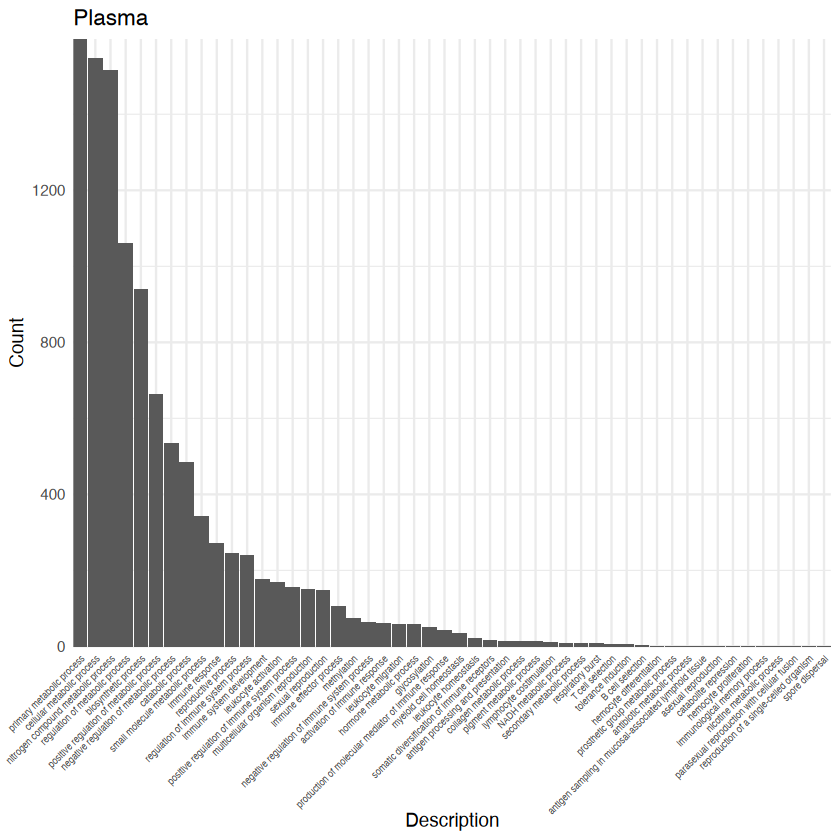

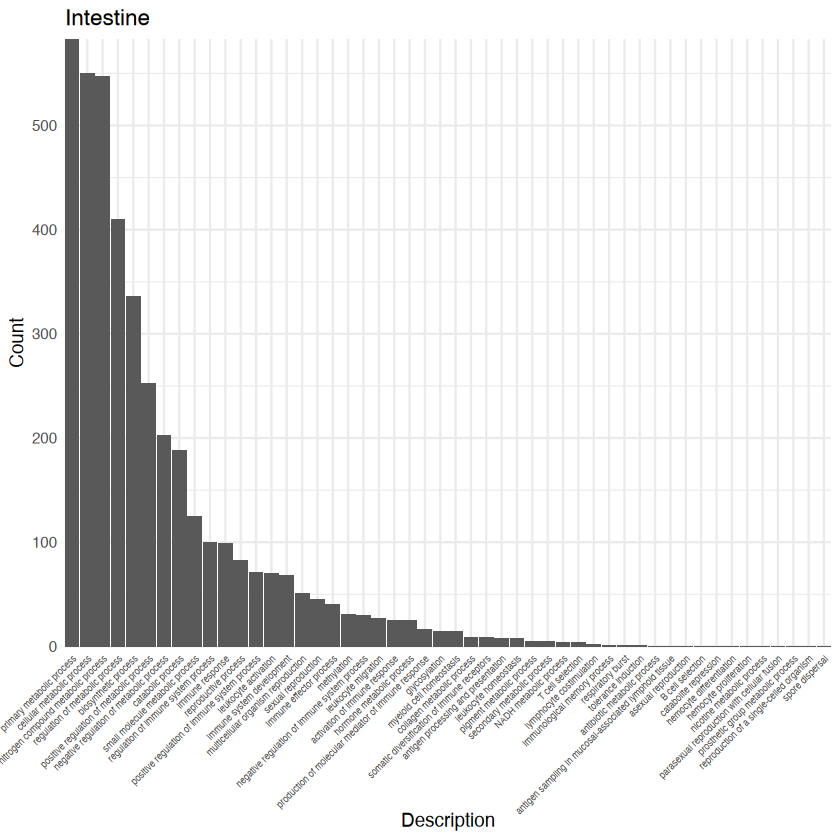

In [42]:
plasBar <- ggplot(PlasBP2GOSum, aes(x = reorder(Description, -Count), y = Count)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(x = "Description", y = "Count", title = "Plasma") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=5)) + 
  scale_x_discrete(expand = c(0, 0))  + scale_y_continuous(expand = c(0, 0))

intBar <- ggplot(IntBP2GOSum, aes(x = reorder(Description, -Count), y = Count)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(x = "Description", y = "Count", title = "Intestine") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=5)) +
  scale_x_discrete(expand = c(0, 0)) + scale_y_continuous(expand = c(0, 0))

plasBar
intBar

### Run enrichment analyses on all the DEP lists

In [43]:
ck <- compareCluster(geneCluster = plas_significant_genes, fun = enrichGO, OrgDb = org.Hs.eg.db, keyType = 'ALIAS', ont = "BP")
ck <- setReadable(ck, OrgDb = org.Hs.eg.db, keyType="ALIAS")

ckPlot <- dotplot(ck, includeAll=TRUE, showCategory=200, label_format=50, font.size=8) + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust =1)) + xlab('') + theme(plot.margin = margin(-1, 0, -1, 0.5))
ggsave('Figures/Plas_GOEnrichDotPlot.png', width=6.5, height=12, dpi=300, units='in')

In [44]:
ckInt <- compareCluster(geneCluster = int_significant_genes, fun = enrichGO, OrgDb = org.Hs.eg.db, keyType = 'ALIAS', ont = "BP")
ckInt <- setReadable(ckInt, OrgDb = org.Hs.eg.db, keyType="ALIAS")

ckIntPlot <- dotplot(ckInt, includeAll=TRUE, showCategory=200, label_format=70, font.size=8) + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + theme(plot.margin = margin(-1, 0, -1, 0.5))
ggsave('Figures/Int_GOEnrichDotPlot.png', width=6.5, height=12, dpi=300, units='in')

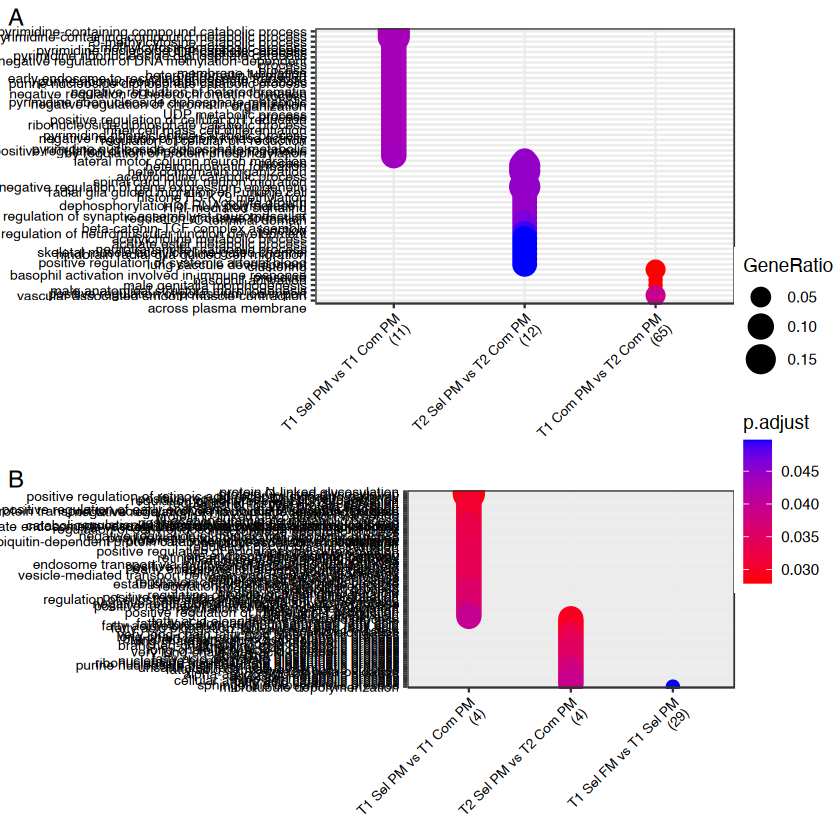

In [45]:
ggpubr::ggarrange(ckPlot, ckIntPlot, ncol = 1, common.legend = TRUE, legend='right', heights=c(.55,.45), labels='AUTO')
ggsave('Figures/GOEnrichDotPlot.png', bg='white', width=6.5, height=12)

In [46]:
set.seed(123)
ckcnet <- cnetplot(ck, showCategory = 25, legend_n=2, shadowtext='category', cexgene=5) + theme(legend.position='top')


ckIntcnet <- cnetplot(ckInt, showCategory = 25, legend_n=2, shadowtext='category', cexgene=5) + theme()


ggsave('Figures/GO_BP_EnrichNet_Plas.tiff', ckcnet, bg='white')
ggsave('Figures/GO_BP_EnrichNet_Int.tiff', ckIntcnet, bg='white')

cnetCombo <- ggpubr::ggarrange(ckcnet, ckIntcnet, ncol=2, common.legend=TRUE, legend='bottom', labels='AUTO')
ggsave('Figures/GO_BP_EnrichNet_Combined.tiff',cnetCombo, bg='white', width=12, height=6.5, units='in')

Warning message in cnetplot.compareClusterResult(x, ...):
“Use 'pie.params = list(legend_n = your_value)' instead of 'legend_n'.
 The legend_n parameter will be removed in the next version.”
Warning message in cnetplot.compareClusterResult(x, ...):
“Use 'pie.params = list(legend_n = your_value)' instead of 'legend_n'.
 The legend_n parameter will be removed in the next version.”
Saving 7 x 7 in image
Saving 7 x 7 in image


#### Calculate GO Semantic similarity on the full proteome of plasma and intestine

In [47]:
#hsGO2 <- godata('org.Hs.eg.db', keytype = "ALIAS", ont="BP", computeIC=FALSE)
#saveRDS(hsGO2, 'Figures/hsGO2.RDS')
hsGO2 <- readRDS('Figures/hsGO2.RDS')
clusterSim(row.names(plas_dep), row.names(int_dep), semData=hsGO2, measure="Wang", combine="BMA")

[1] 0.95